<a href="https://colab.research.google.com/gist/nirshlezinger1/7cf8528f22709fb44fc5e13731758c48/lista-vs-ista.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Unfolding
In this notebook we will compare the iterative soft thresholding algorithm (ISTA) to its deep unfolded version, coined learned ISTA (LISTA). LISTA is in fact the origin of deep unfolding methodology, proposed by Gregor and LeCun back in 2010, and has spurred a multitude of variants over the years. This notebook compares a basic implementation of it to the model-based ISTA, examining the ability of deep unfolding to increase the convergence rate of iterative optimizers. 


In [66]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import torch.nn as nn
from scipy.linalg import eigvalsh 
import numpy as np

import matplotlib.pyplot as plt


torch.manual_seed(0)

torch.set_default_dtype(torch.float64)

## ISTA
We begin by recalling the formulation of ISTA. The original algorihtm aims at solving the LASSO problem
\begin{equation} 
	    \hat{\boldsymbol{s}} = \mathop{\arg\min}\limits_{\boldsymbol{s}} \frac{1}{2}\|\boldsymbol{x}-\boldsymbol{H}\boldsymbol{s}\|^2 +\rho\|\boldsymbol{s}\|_1,
\end{equation}
via the iterative update equations
\begin{equation}
         \boldsymbol{s}^{(k+1)} \leftarrow  \mathcal{T}_{\beta=\mu\rho}\left( \boldsymbol{s}^{(k)} - \mu \boldsymbol{H}^T(\boldsymbol{H}\boldsymbol{s}^{(k)}-\boldsymbol{x}) \right),    
\end{equation}
with $\mathcal{T}$ being the soft-thresholding operation.

Since one can probe convergence of ISTA when the step-size $\mu$ satisfies $\mu \leq \frac{1}{\max {\rm eig}(\boldsymbol{H}^T\boldsymbol{H})}$, we will use this value as our default setting of $\mu = 1/L$ with $L=\max {\rm eig}(\boldsymbol{H}^T\boldsymbol{H})$.

In [67]:
def ista(x, H, rho=0.5, L=1, max_itr=300):
    s = torch.zeros(H.shape[1])
    proj = torch.nn.Softshrink(lambd=rho / L)
    # proj = torch.nn.ReLU()
    for _ in range(max_itr):
        s_tild = s - 1 / L * (H.T @ (H @ s - x))
        s = proj(s_tild)
    return s

## Data
Next, we generate a data set $\mathcal{D}=\{(\boldsymbol{s}_t, \boldsymbol{x}_t)\}_{t=1}^{n_t}$, where each $\boldsymbol{s}_t$ has $m=200$ entries, out of which at most $k=4$ are non-zero, while $\boldsymbol{x}_t$ has $n=150$ entires and is obtained via 
\begin{equation}
\boldsymbol{x}_t = \boldsymbol{H}\boldsymbol{s}_t + \boldsymbol{w}_t,
\end{equation}
with $\boldsymbol{w}_t$ being i.i.d. Gaussian noise.

To that aim, we generate a dedicated class inheriting Dataset to get the data samples, and to allow each tuple to be comprised of both $(\boldsymbol{s}_t, \boldsymbol{x}_t)$ as well as $\boldsymbol{H}$.

In [68]:
class SimulatedData(Data.Dataset): 
    def __init__(self, x, H, s): 
        self.x = x
        self.s = s
        self.H = H 

    def __len__(self):
        return self.x.shape[1]

    def __getitem__(self, idx):
        x = self.x[:, idx] 
        H = self.H
        s = self.s[:, idx]
        return x, H, s


The following is an aid function to convert the noise level from SNR to standard deviation

In [69]:
def snr2std(y, snr):
    s_db = 10 * torch.log10(y.var())
    noise_db = s_db - snr
    noise_std = 10 ** (noise_db / 20)
    return noise_std

The next function creates a dataset. To keep things simple, we use as our labeled data the output of the model-based ISTA with $200$ iterations, rather than the actual sparse signal (which may be difficult to retrieve in some sceanrios). 

In [70]:
def create_data_set(H, n, m, k, N=1000, batch_size=512, snr = 30): 
        # The maximal eigenvalue
        L = float(eigvalsh(H.t() @ H, eigvals=(m - 1, m - 1)))
        # Initialization
        x = torch.zeros(n, N)        
        s = torch.zeros(m, N)
        # Create signals
        for i in range(N):            
            # Random k indices and values
            s_ind = torch.randperm(m)[:k]
            s_nz = torch.randn(k)          
            # Create the signal
            x[:, i] = H[:, s_ind] @ s_nz
            # Add noise to the signal            
            noise = snr2std(x[:, i], snr) * torch.randn(n)
            x[:, i] += noise
            # Create the sparse representation by solving the Basis-Pursuit
            s[:, i] = ista(x=x[:, i], H=H, L=L)
            #x[x_ind, i] = x_nz


        simulated = SimulatedData(x=x, H=H, s=s)
        data_loader = Data.DataLoader(dataset=simulated, batch_size=batch_size, shuffle=True)
        return data_loader

Finally, we generate the data set

In [71]:
#n, m, k = 50, 70, 4
n, m, k = 150, 200, 4
# Measurement matrix
H = torch.randn(n, m)
H /= torch.norm(H, dim=0) 

train_loader = create_data_set(H, n=n, m=m, k=k, N=1000)
test_loader = create_data_set(H, n=n, m=m, k=k, N=1000)

Let's see what the samples look like

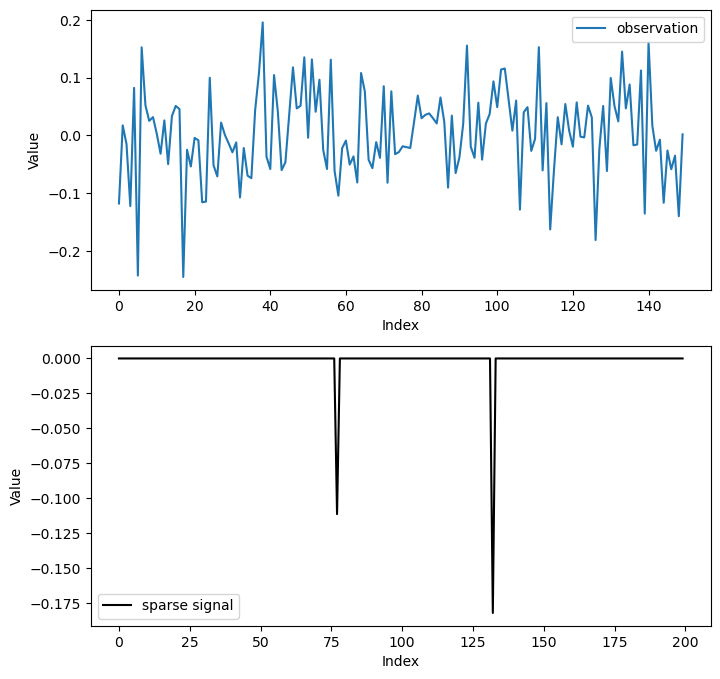

In [72]:
x_exm, _, s_exm =test_loader.dataset.__getitem__(5)
plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 1) 
plt.plot(x_exm, label = 'observation' ) 
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2) 
plt.plot(s_exm, label = 'sparse signal', color='k')  
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.show()

## Train and Validation

For training, we use SGDM with learning rate scheduler and the $\ell_2$ loss

In [73]:
def train(model, train_loader, valid_loader, num_epochs=30):
      """Train a network.
      Returns:
          loss_test {numpy} -- loss function values on test set
      """
      # Initialization
      optimizer = torch.optim.SGD(
          model.parameters(),
          lr=5e-05,
          momentum=0.9,
          weight_decay=0,
      )
      scheduler = torch.optim.lr_scheduler.StepLR(
          optimizer, step_size=50, gamma=0.1
      )
      loss_train = np.zeros((num_epochs,))
      loss_test = np.zeros((num_epochs,)) 
      # Main loop
      for epoch in range(num_epochs):
          model.train()
          train_loss = 0
          for step, (b_x, b_H, b_s) in enumerate(train_loader):
              #b_x, b_H, b_x = b_x.cuda(), b_H.cuda(), b_s.cuda() 
              s_hat = model(b_x)
              loss = F.mse_loss(s_hat, b_s, reduction="sum")
              optimizer.zero_grad()  
              loss.backward()  
              optimizer.step() 
              model.zero_grad()
              train_loss += loss.data.item()
          loss_train[epoch] = train_loss / len(train_loader.dataset)       
          scheduler.step()

          # validation
          model.eval()
          test_loss = 0
          for step, (b_x, b_H, b_s) in enumerate(valid_loader):
              #b_x, b_H, b_x = b_x.cuda(), b_H.cuda(), b_s.cuda()
              s_hat = model(b_x)
              test_loss += F.mse_loss(s_hat, b_s, reduction="sum").data.item()
          loss_test[epoch] = test_loss / len(valid_loader.dataset)
          # Print
          if epoch % 10 == 0:
              print(
                  "     Epoch %d, Train loss %.8f, Validation loss %.8f"
                  % (epoch, loss_train[epoch], loss_test[epoch])
              )


      return loss_test

## Learned ISTA (LISTA)
As noted earlier, there are many variants of unfolded ISTA. Here we should use the following update equation:
\begin{equation}
         \boldsymbol{s}^{(k+1)} \leftarrow  \mathcal{T}_{\beta^{(k)}}\left( \boldsymbol{s}^{(k)} - \mu^{(k)} (\boldsymbol{B}\boldsymbol{s}^{(k)}+\boldsymbol{A}\boldsymbol{x}) \right),    
\end{equation}
with $\boldsymbol{A}, \boldsymbol{B}$ and $\{\beta^{(k)},\mu^{(k)}\}$ beging trainable parameters.

In [74]:
class LISTA_Model(nn.Module):
    def __init__(self, n, m, T=6, rho=1.0, H=None):
        super(LISTA_Model, self).__init__()
        self.n, self.m = n, m
        self.H = H
        self.T = T  # ISTA Iterations
        self.rho = rho  # Lagrangian Multiplier
        self.A = nn.Linear(n, m, bias=False)  # Weight Matrix
        self.B = nn.Linear(m, m, bias=False)  # Weight Matrix
        # ISTA Stepsizes eta 
        self.beta = nn.Parameter(torch.ones(T + 1, 1, 1), requires_grad=True)
        self.mu = nn.Parameter(torch.ones(T + 1, 1, 1), requires_grad=True)
        # Initialization
        if H is not None:
            self.A.weight.data = H.t()
            self.B.weight.data = H.t() @ H 

    def _shrink(self, s, beta):
        return beta * F.softshrink(s / beta, lambd=self.rho)

    def forward(self, x):
        s = self._shrink(self.mu[0, :, :] * self.A(x), self.beta[0, :, :])
        # s = F.relu(self.mu[0, :, :] * self.A(x), self.beta[0, :, :])
        for i in range(1, self.T + 1):           
            s = self._shrink(
                s - self.mu[i, :, :] * self.B(s) + self.mu[i, :, :] * self.A(x),
                self.beta[i, :, :],
            )
            # s = F.relu(
            #     s - self.mu[i, :, :] * self.B(s) + self.mu[i, :, :] * self.A(x),
            #     self.beta[i, :, :],
            # )
        return s


The following functions apply LISTA and ISTA for given data sets

In [75]:
def lista_apply(train_loader, test_loader, T, H):
    n = H.shape[1]
    m = H.shape[1]
    lista = LISTA_Model(n=n, m=m, T=T, H=H)
    # lista.cuda()
 
    loss_test = train(lista, train_loader, test_loader)
    err_lista = loss_test[-1]
    return err_lista

In [76]:
def ista_apply(test_loader, T, H, rho=0.5):
      m = H.shape[1]
      L = float(eigvalsh(H.t() @ H, eigvals=(m - 1, m - 1)))

      loss = 0
      for step, (x, _, s) in enumerate(test_loader.dataset):
          s_hat = ista(x=x, H=H, rho=rho, L=L, max_itr=T)
          loss += F.mse_loss(s_hat, s, reduction="sum").data.item()

      return loss / len(test_loader.dataset)
 


## Comparing LISTA to ISTA
Finally, we show that by learning the parameterization of ISTA in a per-iteration manner, one can notably imporve its convergesnce rate. To that aim, in the following loop we compare ISTA to trained LISTA with different number of iterations.


Iteration : 0
     Epoch 0, Train loss 0.30234347, Validation loss 0.12590201
     Epoch 10, Train loss 0.02453025, Validation loss 0.05172532
     Epoch 20, Train loss 0.01918482, Validation loss 0.03129593
Iteration : 1
     Epoch 0, Train loss 0.34335533, Validation loss 0.19389293
     Epoch 10, Train loss 0.03183971, Validation loss 0.03562023
     Epoch 20, Train loss 0.00126586, Validation loss 0.00375463
Iteration : 2
     Epoch 0, Train loss 0.34155698, Validation loss 0.19145136
     Epoch 10, Train loss 0.03266307, Validation loss 0.03434352
     Epoch 20, Train loss 0.00150247, Validation loss 0.00440648
Iteration : 3
     Epoch 0, Train loss 0.33947600, Validation loss 0.19066012
     Epoch 10, Train loss 0.03366684, Validation loss 0.03407909
     Epoch 20, Train loss 0.00183044, Validation loss 0.00473571
Iteration : 4
     Epoch 0, Train loss 0.33722395, Validation loss 0.19035745
     Epoch 10, Train loss 0.03395973, Validation loss 0.03313906
     Epoch 20, Train loss

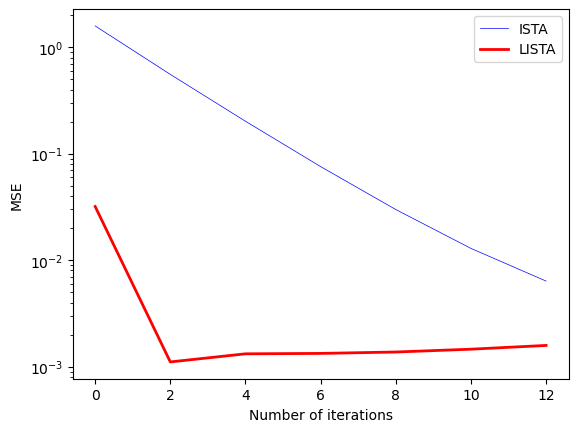

In [78]:
# Number of unfoldings
tstart, tend, tstep = 0, 13, 2
T_opt = range(tstart, tend, tstep)

ista_MSE = []
lista_MSE = []
for i in range(len(T_opt)):
    print(f'Iteration : {i}')
    T = T_opt[i]
    # Apply ISTA with T iterations
    ista_MSE.append(ista_apply(test_loader, T, H))
    # Train and apply LISTA with T iterations / layers
    lista_MSE.append(lista_apply(train_loader, test_loader, T, H))
    
# plot the resutls  
fig = plt.figure()
plt.plot(T_opt, ista_MSE, label='ISTA', color='b',linewidth=0.5)
plt.plot(T_opt, lista_MSE, label='LISTA', color='r', linewidth=2) 
plt.xlabel('Number of iterations', fontsize=10)
plt.ylabel('MSE', fontsize=10)
plt.yscale("log")
plt.legend()
plt.show()